In [1]:
# Core libraries
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline

# Scikit-learn Preprocessing, Models, and Metrics
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    make_scorer,
    classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA

from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import problem
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import VarianceThreshold
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.base import BaseEstimator, TransformerMixin
from collections import Counter
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier


In [2]:
class ROIsFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, :284]

class VBMFeatureExtractor(BaseEstimator, TransformerMixin):
    """Select only the 284 ROIs features:"""
    def fit(self, X, y):
        return self

    def transform(self, X):
        return X[:, 284:]

def no_variance_dropper(X_train, X_test):
    vt = VarianceThreshold(threshold=1e-6)  # Set a low threshold to remove constant features which ruin the models
    X_train = vt.fit_transform(X_train)
    X_test = vt.transform(X_test)
    return X_train, X_test

scaler = StandardScaler()

feROI = ROIsFeatureExtractor()

feVBM = VBMFeatureExtractor()


In [3]:
X_train_full, y_train = problem.get_train_data()
X_test_full, y_test = problem.get_test_data()
y_train_binary = np.where(y_train=="schizophrenia", 1, 0)
y_test_binary = np.where(y_test=="schizophrenia", 1, 0)
assert X_train_full.shape[1] == 284 + 331695


X_train_ROIs = feROI.transform(X_train_full)
X_test_ROIs = feROI.transform(X_test_full)

X_train_VBM = feVBM.transform(X_train_full)
X_test_VBM = feVBM.transform(X_test_full)

X_train_ROIs = scaler.fit_transform(X_train_ROIs)
X_test_ROIs = scaler.transform(X_test_ROIs)

X_train_ROIs, X_test_ROIs = no_variance_dropper(X_train_ROIs, X_test_ROIs)


del X_train_full, X_test_full



In [4]:
print("\n--- L1-based Feature Selection with Logistic Regression ---")
lasso = LogisticRegression(penalty='l1', solver='liblinear', C=0.2, random_state=42)
lasso.fit(X_train_ROIs, y_train_binary)

selector = SelectFromModel(lasso, prefit=True)
X_train_lasso = selector.transform(X_train_ROIs)
X_test_lasso = selector.transform(X_test_ROIs)

X_train_lasso, X_test_lasso = no_variance_dropper(X_train_lasso, X_test_lasso)
print("Number of Selected Features:", X_train_lasso.shape[1])


--- L1-based Feature Selection with Logistic Regression ---
Number of Selected Features: 46


In [5]:


pca_full = PCA()
pca_full.fit(X_train_VBM)

cumsum = np.cumsum(pca_full.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(f"Number of components for 95% variance: {d}")


Number of components for 95% variance: 361


In [6]:
pca_reduced = PCA(n_components=d)
X_train_VBM_pca = pca_reduced.fit_transform(X_train_VBM)
X_test_VBM_pca = pca_reduced.transform(X_test_VBM)


print(f"Original shape: {X_train_VBM.shape}, Reduced shape: {X_train_VBM_pca.shape}")
X_train_VBM_pca, X_test_VBM_pca = no_variance_dropper(X_train_VBM_pca, X_test_VBM_pca)
del X_train_VBM, X_test_VBM


Original shape: (410, 331695), Reduced shape: (410, 361)


In [7]:
print(y_test_binary.shape)
print(X_test_VBM_pca.shape)


(103,)
(103, 361)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, roc_curve, auc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.base import clone

def train_and_test_model(
    X_train,
    y_train,
    X_test,
    y_test,
    model,
    param_grid,
    model_name="Model",
    scoring='roc_auc',
    n_iter=100,          # Number of parameter settings sampled in RandomizedSearchCV
    cv=5,                # Number of cross-validation folds
    n_jobs=-1,
    verbose=1,
    plot=True
):
    """
    Trains and tests a machine learning model with hyperparameter tuning.
    
    Parameters:
    -----------
    X_train : array-like, shape (n_samples_train, n_features)
        Training feature matrix.
    
    y_train : array-like, shape (n_samples_train,)
        Training labels.
    
    X_test : array-like, shape (n_samples_test, n_features)
        Test feature matrix.
    
    y_test : array-like, shape (n_samples_test,)
        Test labels.
    
    model : scikit-learn estimator
        The machine learning model to train (e.g., LogisticRegression, RandomForestClassifier).
    
    param_grid : dict or list of dicts
        Hyperparameter grid for GridSearchCV or RandomizedSearchCV.
    
    model_name : str, default="Model"
        Identifier for the model (used in plots and print statements).
    
    scoring : str, default='roc_auc'
        Scoring metric for evaluation.
    
    search_type : str, default='grid'
        Type of hyperparameter search: 'grid' for GridSearchCV, 'random' for RandomizedSearchCV.
    
    n_iter : int, default=100
        Number of parameter settings sampled in RandomizedSearchCV. Ignored if search_type='grid'.
    
    cv : int, default=3
        Number of cross-validation folds for hyperparameter tuning.
    
    n_jobs : int, default=-1
        Number of jobs to run in parallel for GridSearchCV/RandomizedSearchCV.
    
    verbose : int, default=1
        Verbosity level for GridSearchCV/RandomizedSearchCV.
    
    plot : bool, default=True
        Whether to plot ROC curves.
    
    Returns:
    --------
    best_model : scikit-learn estimator
        The best model found during hyperparameter tuning.
    
    best_params : dict
        The best hyperparameters found during the search.
    
    test_auc : float
        ROC-AUC score on the test set.
    
    test_balanced_accuracy : float
        Balanced accuracy score on the test set.
    """
    
    # Step 1: Split the original training data into new training and validation sets
    X_train_new, X_val, y_train_new, y_val = train_test_split(
        X_train,
        y_train,
        test_size=0.2,
        random_state=42,
        stratify=y_train  # Ensures the class distribution is preserved
    )
    print(f"Training set size: {X_train_new.shape[0]} samples")
    print(f"Validation set size: {X_val.shape[0]} samples\n")

    # Initialize the search method based on search_type


    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        random_state=42,
        n_jobs=n_jobs,
        verbose=verbose
    )
    
    # Fit the search on the training data
    search.fit(X_train, y_train)
    
    # Step 3: Retrieve the best model and parameters
    best_model = search.best_estimator_
    best_params = search.best_params_
    best_score = search.best_score_
    
    print(f"{model_name} - Best Hyperparameters: {best_params}")
    print(f"{model_name} - Best {scoring}: {best_score:.3f}\n")
    
    # Step 4: Retrain the best model on the entire training set
    best_model.fit(X_train, y_train)
    
    # Step 5: Make predictions on the training set
    if hasattr(best_model, "predict_proba"):
        y_proba_train = best_model.predict_proba(X_train)[:, 1]
    else:
        y_proba_train = best_model.decision_function(X_train)
        y_proba_train = (y_proba_train - y_proba_train.min()) / (y_proba_train.max() - y_proba_train.min())

    y_pred_train = best_model.predict(X_train)
    
    # Step 6: Make predictions on the test set
    if hasattr(best_model, "predict_proba"):
        y_proba_test = best_model.predict_proba(X_test)[:, 1]
    else:
        y_proba_test = best_model.decision_function(X_test)
        y_proba_test = (y_proba_test - y_proba_test.min()) / (y_proba_test.max() - y_proba_test.min())

    y_pred_test = best_model.predict(X_test)
    
    # Step 7: Calculate Metrics
    # Training Metrics
    train_auc = roc_auc_score(y_train, y_proba_train)
    train_balanced_accuracy = balanced_accuracy_score(y_train, y_pred_train)
    
    # Test Metrics
    test_auc = roc_auc_score(y_test, y_proba_test)
    test_balanced_accuracy = balanced_accuracy_score(y_test, y_pred_test)
    
    # Compile metrics into a dictionary
    metrics = {
        'Training AUC': train_auc,
        'Training Balanced Accuracy': train_balanced_accuracy,
        'Test AUC': test_auc,
        'Test Balanced Accuracy': test_balanced_accuracy
    }
    
    # Step 8: Print Metrics
    print(f"{model_name} - Training ROC-AUC: {train_auc:.3f}")
    print(f"{model_name} - Training Balanced Accuracy: {train_balanced_accuracy:.3f}")
    print(f"{model_name} - Test ROC-AUC: {test_auc:.3f}")
    print(f"{model_name} - Test Balanced Accuracy: {test_balanced_accuracy:.3f}\n")
    
    # Step 9: Plot ROC curve if required
    if plot:
        plt.figure(figsize=(10, 8))
        
        # ROC curve for Training Set
        fpr_train, tpr_train, _ = roc_curve(y_train, y_proba_train)
        auc_train = auc(fpr_train, tpr_train)
        plt.plot(fpr_train, tpr_train, label=f'Training (AUC = {auc_train:.3f})', color='blue', lw=2)
        
        # ROC curve for Test Set
        fpr_test, tpr_test, _ = roc_curve(y_test, y_proba_test)
        auc_test = auc(fpr_test, tpr_test)
        plt.plot(fpr_test, tpr_test, label=f'Test (AUC = {auc_test:.3f})', color='red', lw=2)
        
        # Plot the diagonal line for chance
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=2, label='Chance')
        
        plt.title(f"{model_name} - ROC-AUC Curves")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.grid(alpha=0.2)
        plt.show()
    
    return best_model, best_params, metrics

Training set size: 328 samples
Validation set size: 82 samples

Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=200. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Random Forest - Best Hyperparameters: {'random_state': 42, 'n_estimators': 20, 'min_samples_split': 30, 'min_samples_leaf': 4, 'max_depth': 4, 'bootstrap': True}
Random Forest - Best roc_auc: 0.808

Random Forest - Training ROC-AUC: 0.926
Random Forest - Training Balanced Accuracy: 0.854
Random Forest - Test ROC-AUC: 0.834
Random Forest - Test Balanced Accuracy: 0.748



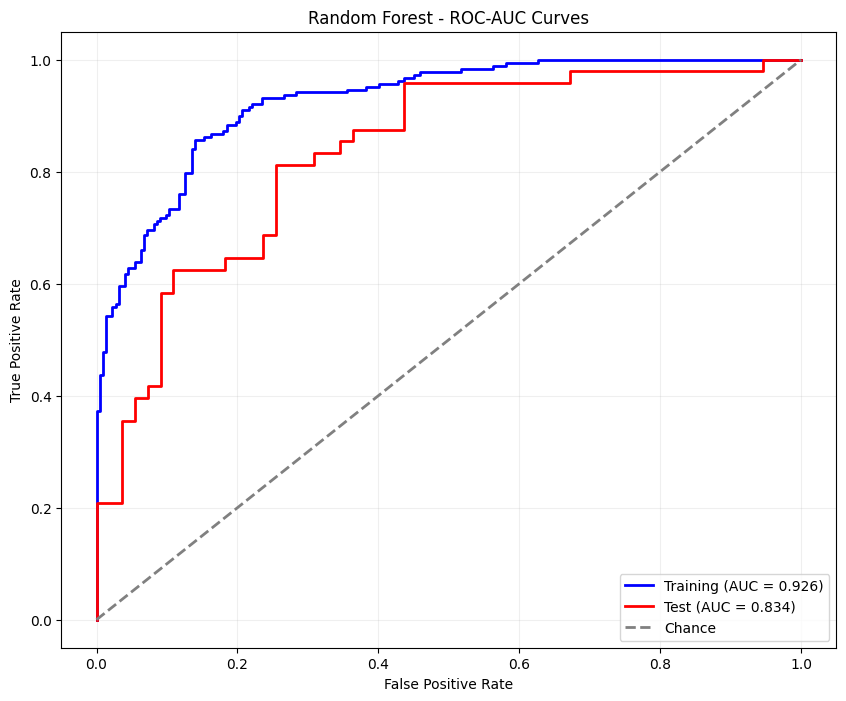

In [9]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model
rf_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Define the hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [20],        # Number of trees in the forest
    'max_depth': [4],          # Maximum depth of the tree
    'min_samples_split': [20, 30],    # Minimum samples required to split a node
    'min_samples_leaf': [3, 4, 6],      # Minimum samples required at a leaf node
    'bootstrap': [True],
    'random_state': [42],
}

# Call the function
best_rf, best_params_rf, metrics_rf = train_and_test_model(
    X_train=X_train_lasso,
    y_train=y_train_binary,
    X_test=X_test_lasso,
    y_test=y_test_binary,
    model=rf_clf,
    param_grid=param_grid_rf,
    model_name="Random Forest",
    scoring='roc_auc',
    cv=5,
    n_iter=200, 
    n_jobs=-1,
    verbose=2,
    plot=True
)


Training set size: 328 samples
Validation set size: 82 samples

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Log Reg - Best Hyperparameters: {'solver': 'liblinear', 'random_state': 42, 'penalty': 'l2', 'max_iter': 200, 'C': 0.01}
Log Reg - Best roc_auc: 0.872

Log Reg - Training ROC-AUC: 0.897
Log Reg - Training Balanced Accuracy: 0.807
Log Reg - Test ROC-AUC: 0.834
Log Reg - Test Balanced Accuracy: 0.765



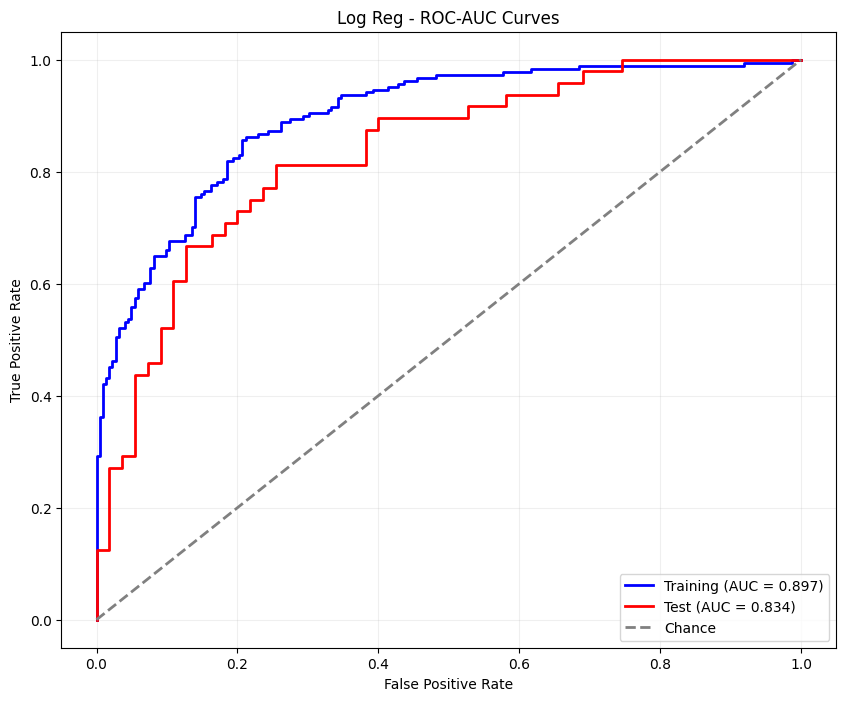

In [10]:
log_reg = LogisticRegression(class_weight='balanced', random_state=42)

param_grid_log_reg = [
    {'C': [0.01],
        'solver': ['liblinear'],
        'max_iter': [200],
        'penalty': ['l1', 'l2'],  # l1 and l2 penalties with liblinear solver
        'random_state': [42]},

    {'C': [0.01],
        'solver': ['lbfgs', 'newton-cg'],
        'max_iter': [200],
        'penalty': ['l2'],  # l2 penalty with lbfgs and newton-cg solvers
        'random_state': [42]}
]

# Initialize Logistic Regression

best_log_reg, best_params_log_reg, metrics_log_reg = train_and_test_model(
    X_train=X_train_lasso,
    y_train=y_train_binary,
    X_test=X_test_lasso,
    y_test=y_test_binary,
    model=log_reg,
    param_grid=param_grid_log_reg,
    model_name="Log Reg",
    scoring='roc_auc',
    cv=5,
    n_iter=4, 
    n_jobs=-1,
    verbose=2,
    plot=True
)


Training set size: 328 samples
Validation set size: 82 samples

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
Grad Boost - Best Hyperparameters: {'subsample': 0.6, 'random_state': 42, 'n_iter_no_change': 10, 'n_estimators': 110, 'min_samples_split': 25, 'min_samples_leaf': 30, 'max_features': 'log2', 'max_depth': 3, 'learning_rate': 0.05}
Grad Boost - Best roc_auc: 0.854

Grad Boost - Training ROC-AUC: 0.943
Grad Boost - Training Balanced Accuracy: 0.840
Grad Boost - Test ROC-AUC: 0.823
Grad Boost - Test Balanced Accuracy: 0.762



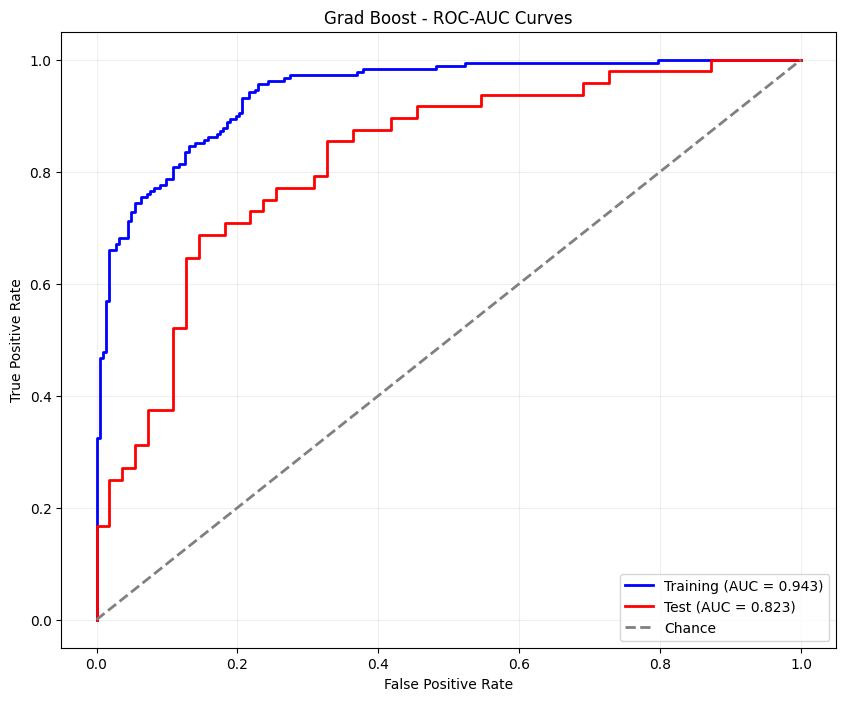

In [96]:


param_dist_grad_boost = {
    'n_estimators': range(30, 120, 10),                # Wider range for the number of trees
    'learning_rate': [0.01, 0.05, 0.1],   # Fine-grained control over learning rate
    'max_depth': range(2, 5, 1),                     # Wider range of tree depths
    'min_samples_split': range(10, 50, 5),             # Broad range for minimum samples to split
    'min_samples_leaf': range(20, 50, 5),              # Broad range for minimum samples in leaves
    'max_features': ['sqrt', 'log2'],  # Varying max features
    'subsample': [ 0.6, 0.8],                # Include full and partial subsampling
    'n_iter_no_change': [5, 10],                  # Adjust early stopping sensitivity
    'random_state': [42]                              # Fixed for reproducibility
}


# Initialize Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)

best_grad_boost, best_params_log_reg, metrics_log_reg = train_and_test_model(
    X_train=X_train_lasso,
    y_train=y_train_binary,
    X_test=X_test_lasso,
    y_test=y_test_binary,
    model=gb,
    param_grid=param_dist_grad_boost,
    model_name="Grad Boost",
    scoring='roc_auc',
    cv=5,
    n_iter=1000, 
    n_jobs=-1,
    verbose=2,
    plot=True
)

Training set size: 328 samples
Validation set size: 82 samples

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=1000. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


SVM - Best Hyperparameters: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.004}
SVM - Best roc_auc: 0.869

SVM - Training ROC-AUC: 0.895
SVM - Training Balanced Accuracy: 0.815
SVM - Test ROC-AUC: 0.836
SVM - Test Balanced Accuracy: 0.753



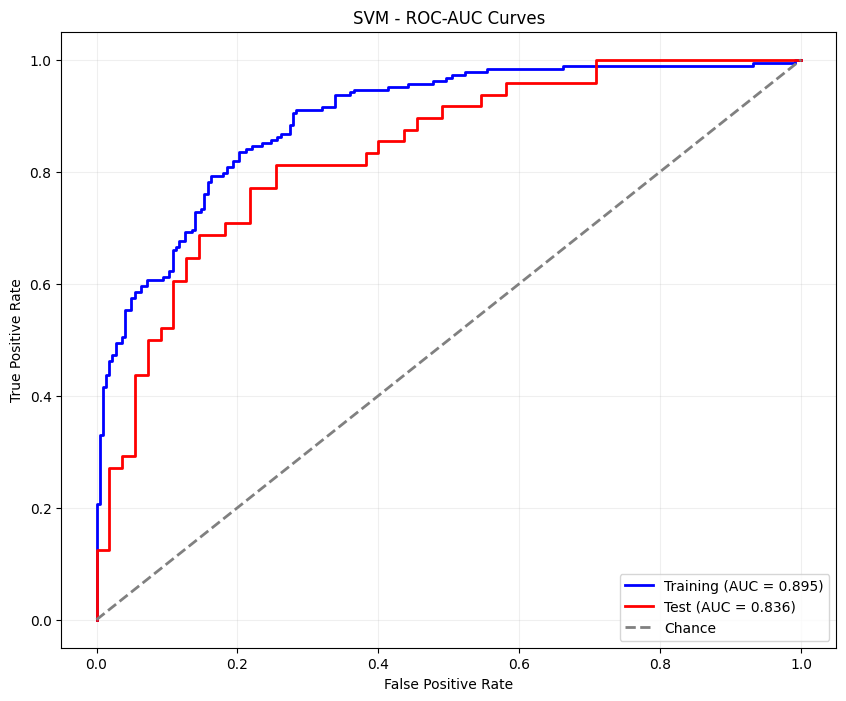

In [94]:
param_grid_svm = {
        'C': [0.004],          # Regularization strength
        'kernel': ['linear', 'rbf'],  # Linear and radial basis function kernels
        'gamma': ['scale', 'auto']    # Kernel coefficient for 'rbf'
    }

    # Initialize SVM model
svm = SVC(probability=True, class_weight='balanced', random_state=42)

best_svm, best_params_svm, metrics_svm = train_and_test_model(
    X_train=X_train_lasso,
    y_train=y_train_binary,
    X_test=X_test_lasso,
    y_test=y_test_binary,
    model=svm,
    param_grid=param_grid_svm,
    model_name="SVM",
    scoring='roc_auc',
    cv=5,
    n_iter=1000, 
    n_jobs=-1,
    verbose=2,
    plot=True
)


Training set size: 328 samples
Validation set size: 82 samples

Fitting 5 folds for each of 100 candidates, totalling 500 fits
NuSVC - Best Hyperparameters: {'nu': 0.5, 'kernel': 'linear', 'gamma': 'scale', 'degree': 4, 'coef0': 0.0}
NuSVC - Best roc_auc: 0.882

NuSVC - Training ROC-AUC: 0.920
NuSVC - Training Balanced Accuracy: 0.823
NuSVC - Test ROC-AUC: 0.831
NuSVC - Test Balanced Accuracy: 0.762



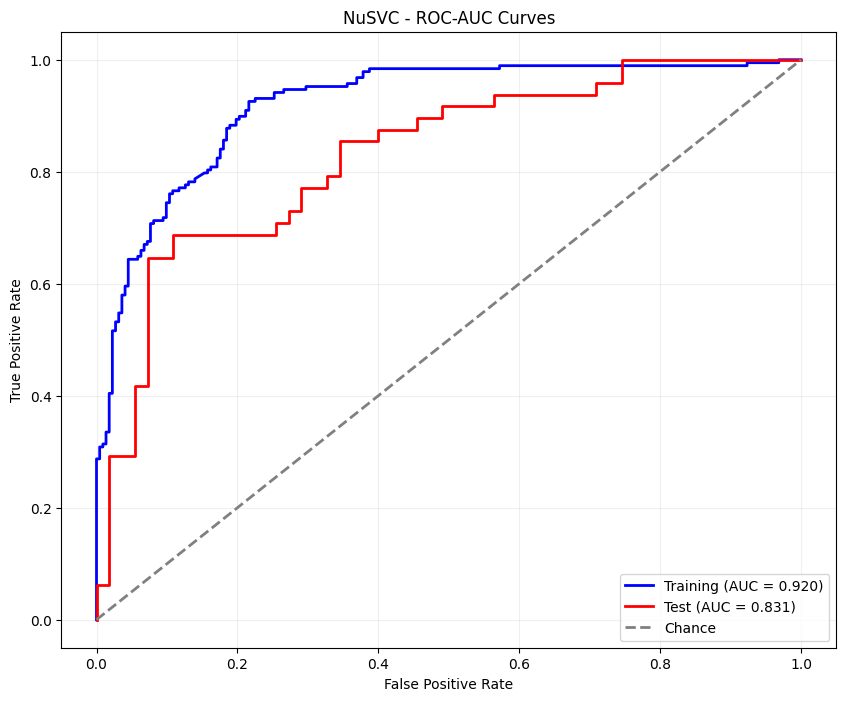

In [13]:
from sklearn.svm import NuSVC

# Define the NuSVC model
nu_svc = NuSVC(probability=True, class_weight='balanced', random_state=42)

# Define the parameter grid for NuSVC
param_grid_nu_svc = {
    'nu': [0.1, 0.3, 0.5, 0.6],  # Fraction of training errors or support vectors
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Kernel types
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [2, 3, 4],         # Degree for 'poly' kernel
    'coef0': [0.0, 0.1, 0.5],    # Independent term in kernel function for 'poly' and 'sigmoid'

    
}

best_nu_svc, best_params_nu_svc, metrics_nu_svc = train_and_test_model(
    X_train=X_train_lasso,
    y_train=y_train_binary,
    X_test=X_test_lasso,
    y_test=y_test_binary,
    model=nu_svc,
    param_grid=param_grid_nu_svc,
    model_name="NuSVC",
    scoring='roc_auc',
    cv=5,
    n_iter=100,  # Randomized search
    n_jobs=-1,
    verbose=2,
    plot=True
)


In [20]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both training and test data



Training set size: 328 samples
Validation set size: 82 samples

Fitting 5 folds for each of 1 candidates, totalling 5 fits


C:\Users\-\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=200. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


MLPClassifier - Best Hyperparameters: {'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (150, 50, 50), 'early_stopping': True, 'batch_size': 32, 'alpha': 0.06, 'activation': 'logistic'}
MLPClassifier - Best roc_auc: 0.854

MLPClassifier - Training ROC-AUC: 0.895
MLPClassifier - Training Balanced Accuracy: 0.809
MLPClassifier - Test ROC-AUC: 0.855
MLPClassifier - Test Balanced Accuracy: 0.757



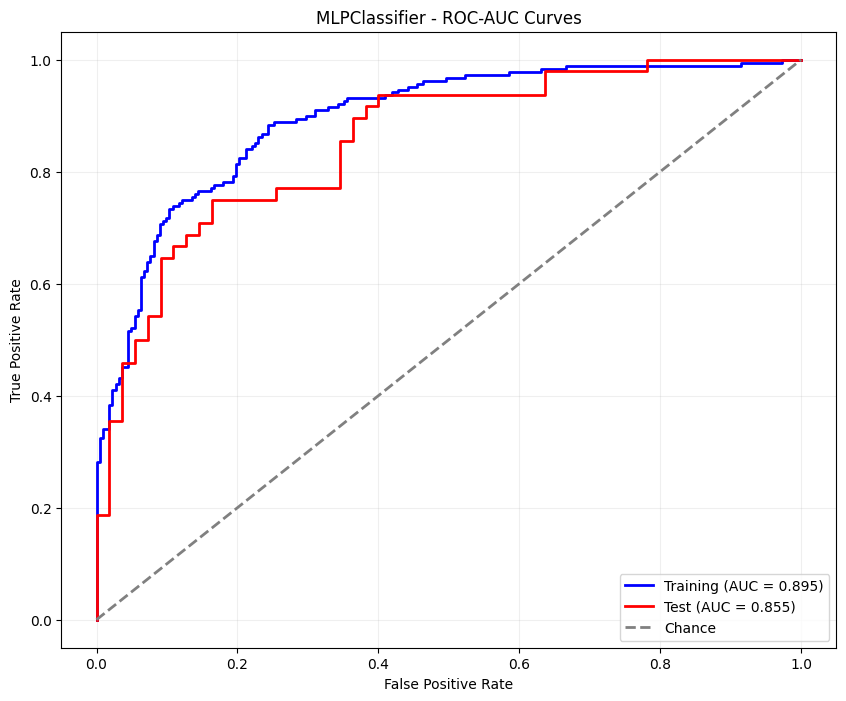

"MLPClassifier - Best Hyperparameters: {'n_iter_no_change': 20, 'momentum': 0.95, 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (150, 50, 50), 'early_stopping': True, 'batch_size': 32, 'alpha': 0.05, 'activation': 'logistic'}\nMLPClassifier - Best roc_auc: 0.863\n"

In [93]:
X_train_scaled = scaler.fit_transform(X_train_lasso)
X_test_scaled = scaler.transform(X_test_lasso)
# Initialize MLPClassifier

mlp = MLPClassifier(random_state=42, max_iter=200)

# Define the comprehensive parameter grid for MLP
param_grid_mlp = {
    'hidden_layer_sizes': [
     (150, 50,50,)
    ],
    'activation': ['logistic'],
    'alpha': [ 0.06],
    'learning_rate': ['adaptive'],
    'learning_rate_init': [0.01],
    'batch_size': [32],
    'early_stopping': [True],
}

# Call the train_and_test_model function
best_mlp, best_params_mlp, metrics_mlp = train_and_test_model(
    X_train=X_train_scaled,
    y_train=y_train_binary,
    X_test=X_test_scaled,
    y_test=y_test_binary,
    model=mlp,
    param_grid=param_grid_mlp,
    model_name="MLPClassifier",
    scoring='roc_auc',
    n_iter=200,                # Number of parameter settings to sample
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  # Stratified K-Fold
    n_jobs=-1,                 # Use all available cores
    verbose=2,                 # Verbose output for progress tracking
    plot=True                  # Plot the ROC curve
)
'''MLPClassifier - Best Hyperparameters: {'n_iter_no_change': 20, 'momentum': 0.95, 'learning_rate_init': 0.01, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (150, 50, 50), 'early_stopping': True, 'batch_size': 32, 'alpha': 0.05, 'activation': 'logistic'}
MLPClassifier - Best roc_auc: 0.863
'''


In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
# Initialize the VotingClassifier with the best models
ensemble_clf = VotingClassifier(
    estimators=[
        ('rf', best_rf),
        ('log_reg', best_log_reg),
        ('svm', best_svm),
        ('nu_svc', best_nu_svc),
        ('mlp', best_mlp)
    ],
    voting='soft',  # 'soft' uses predicted probabilities
    n_jobs=-1        # Utilize all available cores
)
ensemble_clf.fit(X_train_lasso, y_train_binary)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=4,
                                                     min_samples_leaf=4,
                                                     min_samples_split=30,
                                                     n_estimators=20,
                                                     random_state=42)),
                             ('log_reg',
                              SVC(C=0.004, class_weight='balanced',
                                  kernel='linear', probability=True,
                                  random_state=42)),
                             ('svm',
                              SVC(C=0.004, class_weight='balanced',
                                  kernel='linear', probability=True,
                                  random_state=42)),
                             ('mlp',
                              MLPClassifier(activation='logistic', alpha=0.06,
                                            batch_size=32, early_stopping=True,
                                            hidden_layer_sizes=(150, 50, 50),
                                            learning_rate='adaptive',
                                            learning_rate_init=0.01,
                                            random_state=42))],
                 n_jobs=-1, voting='soft')

In [106]:
# Make predictions on the test set
y_proba_ensemble = ensemble_clf.predict_proba(X_test_lasso)[:, 1]
y_pred_ensemble = ensemble_clf.predict(X_test_lasso)

# Calculate Metrics
test_auc_ensemble = roc_auc_score(y_test_binary, y_proba_ensemble)
test_balanced_accuracy_ensemble = balanced_accuracy_score(y_test_binary, y_pred_ensemble)

# Print Metrics
print(f"Ensemble Classifier - Test ROC-AUC: {test_auc_ensemble:.3f}")
print(f"Ensemble Classifier - Test Balanced Accuracy: {test_balanced_accuracy_ensemble:.3f}\n")


Ensemble Classifier - Test ROC-AUC: 0.841
Ensemble Classifier - Test Balanced Accuracy: 0.762

